# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df1.head(1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062


In [4]:
def exploratory(data):
    print(f"Shape:    {data.shape}")
    print("Na's:         ", data.isna().sum().sum())
    print("duplicates:   ", data.duplicated().sum())
    print("\nРаспределение признаков:")
    data[["f0","f1","f2"]].hist()
    plt.show()

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


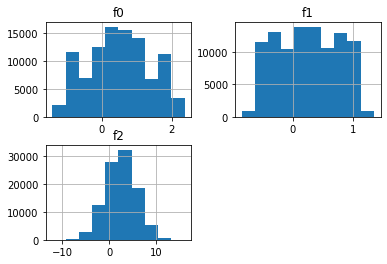

In [5]:
exploratory(df1)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


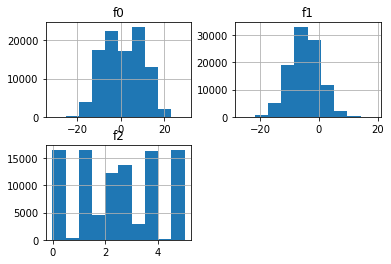

In [6]:
exploratory(df2)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


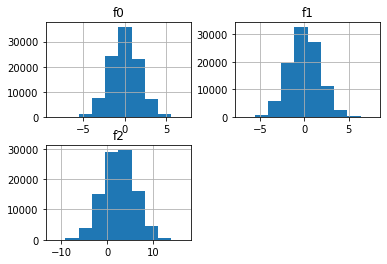

In [7]:
exploratory(df3)

# 2. Обучение и проверка модели

In [8]:
def split_and_train(data):
    """
    Функция берет на вход датасет.
    
    Оставляет только нужные признаки,
    Делит df на train и test, шкалирует.
    
    Обучает линейную модель
    
    Возвращает tuple с предсказаниями, labelы, RMSE
    """
    
    features = data.drop(["product","id"], axis=1)
    target = data["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=1)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product: {0:.2f}".format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

In [9]:
i = 1
for region in [df1, df2, df3]:
    print(f"Region {i}:")
    print("\n---------")
    split_and_train(region)
    print("-----------------------\n\n")
    i+=1

Region 1:

---------
RMSE: 37.74
Average product: 92.49
-----------------------


Region 2:

---------
RMSE: 0.89
Average product: 69.12
-----------------------


Region 3:

---------
RMSE: 39.87
Average product: 94.96
-----------------------




In [10]:
# Save predictions, true values and RMSE
predictions_1, validation_1, rmse_1 = split_and_train(df1)
predictions_2, validation_2, rmse_2 = split_and_train(df2)
predictions_3, validation_3, rmse_3 = split_and_train(df3)

RMSE: 37.74
Average product: 92.49
RMSE: 0.89
Average product: 69.12
RMSE: 39.87
Average product: 94.96


# 3. Подготовка к расчёту прибыли

In [11]:
budget = 10**10 
income_per_barrel = 450 * 10**3 

**Точка безубыточности**
$$ budget - income * n = 0  $$
$$ n = \frac{budget}{income} $$  

In [12]:
n = budget / income_per_barrel
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(n))

Точка безубыточности: 22222 тыс. баррелей


In [13]:
print("Средний объем нефти в скважине для безубыточного функционирования:", np.ceil(n/200))

Средний объем нефти в скважине для безубыточного функционирования: 112.0


#### Вывод:
>    - Запас сырья в скважинах меньше, чем точка безубыточности.

# 4. Расчёт прибыли и рисков 

In [14]:
def profit_1(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * income_per_barrel
    return revenue - budget

In [15]:
state = np.random.RandomState(42)

In [16]:
def find_conf_interval_and_loss_risk(predictions, target):
    revenue = []
    for _ in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit_1(predictions_sample, target_sample))   # ПОДСТАВИЛ НОВУЮ ФУНКЦИЮ profit_1
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)

In [17]:
i = 1
for preds, target in zip([predictions_1, predictions_2, predictions_3], 
                         [validation_1, validation_2, validation_3]):
    interval, mean_revenue, risk = find_conf_interval_and_loss_risk(preds, target)
    print(f"Region {i}:")
    print("\n-----------------------------------------")
    print(f"Mean: {mean_revenue}")
    print(f"95% confidence interval: {interval}")
    print(f"Risk of loss: {risk}")
    print("-----------------------------------------\n\n")
    i+=1

Region 1:

-----------------------------------------
Mean: 483620020
95% confidence interval: (-54499686, 999922208)
Risk of loss: 3.2
-----------------------------------------


Region 2:

-----------------------------------------
Mean: 541232380
95% confidence interval: (99573508, 963619380)
Risk of loss: 1.1
-----------------------------------------


Region 3:

-----------------------------------------
Mean: 408477739
95% confidence interval: (-147436391, 964607821)
Risk of loss: 7.3
-----------------------------------------




### Вывод:
>   
    1. В начале мы провели исследовательский анализ данных, проверили датасеты на наличие пропусков, дупликатов, а также посмотрели на распределения признаков, которые, в общем, оказались распределены не нормально.
    2. Построили линейную модель, для предсказания объемов нефти в скважинах.
    3. Затем мы выполнили процедуру бутстрэпа и нашли 95% доверительный интервал для среднего объема нефти в скважинах. Наиболее перспективным для разработки представляется регион № 2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.